# Introduction.

### This project mainly focuses on the topic of Anomaly detection were we have the readings of the fridge's sensor and depending on the change in the behaviour of the temperature  we could easily detect the anomaly degrees of temperature using Hidden Markov model. This process is done in 3 phases which are:

- Constructing the Hidden Markov model.
- Computing the detection threshold.
- Anomaly detection.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import datetime as dt
import random
import statistics as st
import math
import warnings

warnings.filterwarnings('ignore')

### Exploratory Data analysis and Preprocessing. 

In [2]:
df = pd.read_csv(r'sensor_logs_1.csv')

In [3]:
# Taking a copy of the dataframe in order not to damage the original data.
df1 = df.copy()

In [4]:
df1.head()

,Average Temperature,Maximum Temperature,Minimum Temperature,Average Humidity,Created AT
0,-5.74,-1.4,-8.4,92.7,2022-08-30 21:40:43
1,-0.41,0.0,-1.4,99.9,2022-08-30 21:37:43
2,-0.68,-0.3,-1.6,99.9,2022-08-30 21:34:43
3,-1.60,-1.6,-1.6,99.9,2022-08-30 21:31:19
4,-12.17,-11.6,-12.6,93.9,2022-08-30 17:03:47


In [5]:
df1.info()
# The data is clean with no nulls so no need for data cleansing.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13698 entries, 0 to 13697
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Average Temperature  13698 non-null  float64
 1   Maximum Temperature  13698 non-null  float64
 2   Minimum Temperature  13698 non-null  float64
 3   Average Humidity     13698 non-null  float64
 4   Created AT           13698 non-null  object 
dtypes: float64(4), object(1)
memory usage: 535.2+ KB


In [6]:
df1['Created AT'] = pd.to_datetime(df1['Created AT'])

### Plotting the distribution of the temperature of the fridge's sensor.

<AxesSubplot:xlabel='Average Temperature', ylabel='Density'>

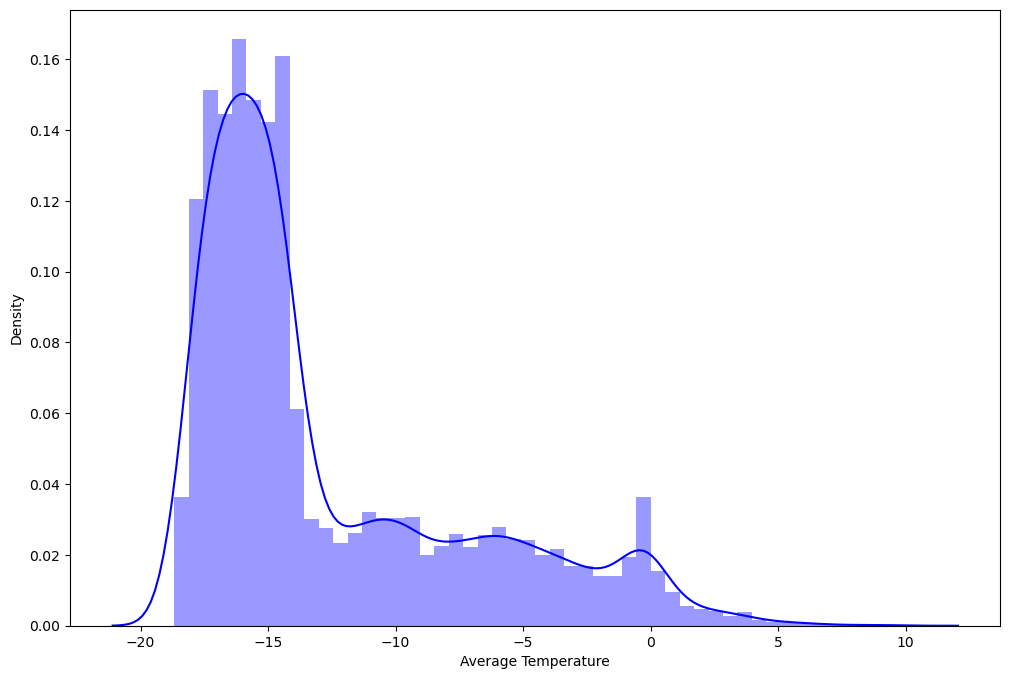

In [7]:
plt.figure(figsize=(12,8))
Av_temp = df1['Average Temperature']
sns.distplot(Av_temp, color='b')

# Phase 1 : Constructing the hidden markov model.


### 1- States identification.

- In our Hidden Markov model we will we assume 4 states were each state represent a certain range of temperature.
- Each index in the returned array of the function get_states represent a state. index 0 --> S1 etc

In [8]:
def get_states(data,Ns):
    States = []
    Max_temp = math.ceil(data['Maximum Temperature'].max()) 
    Min_temp = math.floor(data['Minimum Temperature'].min())
    step = (Max_temp-Min_temp)/Ns
    for i in range(Ns):
        start = Min_temp 
        end = Min_temp + step
        Min_temp = end
        Range = np.array([np.arange(start , end  , 0.5)])
        States.append(Range)
    
    return States

In [9]:
States = get_states(df1 , 4)
States

[array([[-19. , -18.5, -18. , -17.5, -17. , -16.5, -16. , -15.5, -15. ,
         -14.5, -14. , -13.5, -13. , -12.5, -12. ]]),
 array([[-11.5, -11. , -10.5, -10. ,  -9.5,  -9. ,  -8.5,  -8. ,  -7.5,
          -7. ,  -6.5,  -6. ,  -5.5,  -5. ,  -4.5]]),
 array([[-4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,
          1.5,  2. ,  2.5,  3. ]]),
 array([[ 3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,
          9. ,  9.5, 10. , 10.5]])]

### 2- Generating the transition matrix.
- This function returns a 4x4 array were each index represent the total number of transitions done from a state to another.
- Ex : index (1,2) represent the transitions that was done from State 1 to State 2.

In [10]:
def get_Transition_Matrix(data , states):
    Transition_matrix = np.zeros((4, 4))
    length =len(data)-1

    for i in range(length):
        x = int(data['Average Temperature'][i])
        y = int(data['Average Temperature'][i+1])
        
        for n in range(len(states)):
            if x in states[n][0]:
                
                for j in range(len(states)):
                    if y in states[j][0]:
                        Transition_matrix[n][j] +=1
    return Transition_matrix

In [11]:
Transition_matrix = get_Transition_Matrix(df1,States)
Transition_matrix

array([[9.199e+03, 1.590e+02, 3.000e+00, 0.000e+00],
       [1.580e+02, 2.202e+03, 1.760e+02, 0.000e+00],
       [4.000e+00, 1.750e+02, 1.560e+03, 1.300e+01],
       [0.000e+00, 0.000e+00, 1.300e+01, 3.500e+01]])

- The below function gets the sum of each row's transition which we will use to get the probability matrix.

In [12]:
def Sum_of_Trans_rows(Transition_matrix):
    Ts = []
    for i in range(len(Transition_matrix)):
        total = 0
        for j in range(len(Transition_matrix)):
            total += Transition_matrix[i][j]
        Ts.append(total)
    return Ts

In [13]:
Ts = Sum_of_Trans_rows(Transition_matrix)
Ts

[9361.0, 2536.0, 1752.0, 48.0]

### 2- Generating the probability matrix.
- This function returns a 4x4 array were each index represent the pobability to transfer from a state to another.
- Ex : index (1,2) represent the probability to transfer from State 1 to State 2.

In [14]:
def get_probability_matrix(Transition_matrix , Ts):
    
    probability_matrix = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            n = Ts[i]
            if n != 0:
                x = (Transition_matrix[i][j]) / (n)
                probability_matrix[i][j]=x
            else:
                probability_matrix[i][j]=0
    return probability_matrix 

In [15]:
prob_mat = get_probability_matrix(Transition_matrix , Ts)
prob_mat

array([[9.82694157e-01, 1.69853648e-02, 3.20478581e-04, 0.00000000e+00],
       [6.23028391e-02, 8.68296530e-01, 6.94006309e-02, 0.00000000e+00],
       [2.28310502e-03, 9.98858447e-02, 8.90410959e-01, 7.42009132e-03],
       [0.00000000e+00, 0.00000000e+00, 2.70833333e-01, 7.29166667e-01]])

# Phase 2 : Computing the detecion threshold.

### 1- Calculating the Root mean square error.
- In this phase we divide our data frame into subintervals (Days) and for each subinterval we get the transition and the probabilty matrix then we calculate the Root mean square error between each subinterval and the whole intervals of data calculated before.

- Note that p1 here is the probability matrix of all intervals and q1 is the probability matrix of 1 subinterval.

In [16]:
def get_RMSE(p1 , q1):
    RMSE = np.zeros(4)
    for i in range(len(p1)):
        Q = []
        P = []
        for j in range(len(p1)):
            Q.append(q1[i][j])
            P.append(p1[i][j])
        MSE = np.square(np.subtract(Q,P)).mean()   
        RMSE[i] = (math.sqrt(MSE))
    return RMSE

### 2- Calculating the factors that will be used for choosing the threshold.
- This RMSE is used to calculate a detection factor for each subinterval. At the end of this phase, the detection threshold is calculated as a function of all detection factors computed in all subintervals.

- The significance of the prioritization vector 𝑷 is that it assigns higher priorities to source HMM states with higher number of transitions beginning at these states.

- Subinterval detection factor 𝐹𝑗 is calculated as the sum of all rows of the prioritization vector 𝑷, where 𝑗 is the index of the current subinterval.


In [17]:
def get_factor(RMSE , data , subinterval):
    states = get_states(data,4)
    Transition_Sub = get_Transition_Matrix(subinterval,states)
    T_val = Sum_of_Trans_rows(Transition_Sub)
    T_total = sum(T_val)
    priority = np.zeros(4)
    for i in range(4):
        priority[i] = RMSE[i] * (T_val[i]/T_total)
    Fj = sum(priority)
    return Fj

- The previous function was only demonstrated for a single subinterval. However, it should be executed for all subintervals within this phase.
- factor vector 𝑭 would eventually contain the detection factors of all 30 Days (subintervals) at the end of this phase, as follows.

In [18]:
def All_Factors(data):
    df_temp = data.copy()
    days = []
    [days.append(df_temp['Created AT'][i].day) for i in range(len(df_temp)) if df_temp['Created AT'][i].day not in days];
    # preparing for the original dataframe components.
    
    states = get_states(data,4)
    Transition_matrix_all = get_Transition_Matrix(data,states)
    Ts_all = Sum_of_Trans_rows(Transition_matrix)
    Probability_matrix_all = get_probability_matrix(Transition_matrix_all,Ts_all)
    
    
    Factors = []
    
    for i in range(len(days)):
        subinterval =  df_temp.loc[df_temp['Created AT'].dt.day == days[i]]
        subinterval = subinterval.reset_index()
        
        Transition_matrix_sub = get_Transition_Matrix(subinterval,states)
        Ts_sub = Sum_of_Trans_rows(Transition_matrix_sub)
        Ts_total_sub = sum(Ts_sub)
        
        q = get_probability_matrix(Transition_matrix_sub , Ts_sub)
        
        RMSE = get_RMSE(Probability_matrix_all , q)
        
        Fj = get_factor(RMSE ,data, subinterval)
        
        Factors.append(Fj)
    return Factors

In [19]:
Factors = All_Factors(df1)
Factors

[0.01563921415593814,
 0.0051776810210963,
 0.014012575154887423,
 0.014918165374793627,
 0.008471953224082306,
 0.009379259674936772,
 0.013774349095359104,
 0.01315180249199604,
 0.013562615131652637,
 0.01078294920887004,
 0.009225109274015137,
 0.008688837630026756,
 0.013152267848721555,
 0.011281180258774219,
 0.022098395701193624,
 0.011191323700363185,
 0.008656996725428339,
 0.0041769867367852384,
 0.005421972881744249,
 0.011659359846524778,
 0.0057841328059204744,
 0.008563293890600938,
 0.004754039173257026,
 0.005142784865258843,
 0.009574458311119312,
 0.009961464524670291,
 0.017981104229846032,
 0.0383376339350608,
 0.05028018407951391,
 0.052748576848483865]

### The above values is what we will use to decide the detection threshold.

In [20]:
F_max = max(Factors)
F_mean = st.mean(Factors)
F_Mean_Std = F_mean + st.pstdev(Factors)

print("the  first threshold " ,F_max)
print ("the second threshold " , F_mean)
print ("the third threshold ", F_Mean_Std)

the  first threshold  0.052748576848483865
the second threshold  0.014251688926697365
the third threshold  0.026086864664851432


### By trial and error the F_max was choosen as the detection threshold.

# Phase 3 : Anomaly detection.

### This function will be used to detect the anomaly degrees of temperature it takes as a parameter the original data to which will be a reference to train the model on and the damaged data to check for anomaly degrees of temperature in different days.
- This will be done by comparing the Factor 𝐹𝑗 of each subinterval in the damaged data with the data detection threshold computed from the original data.
- if 𝐹𝑗 > 𝐹_Threshold,  Therefor Anomaly is detected.

-  **Note:** this function takes two parameter , the first is the good data to train on it and the second is the damaged data.

In [21]:
def predict_anomaly(original_data , testing):
    Fact = All_Factors(original_data)
    Threshold = max(Fact)
    days = []
    [days.append(testing['Created AT'][i].day) for i in range(len(testing)) if testing['Created AT'][i].day not in days];
    
    states = get_states(original_data,4)
    Transition_matrix_all = get_Transition_Matrix(original_data,states)
    Ts_all = Sum_of_Trans_rows(Transition_matrix_all)
    Probability_matrix_all = get_probability_matrix(Transition_matrix_all,Ts_all)
    
    for i in range(len(days)):
        subint =  testing.loc[testing['Created AT'].dt.day == days[i]]
        subint = subint.reset_index()
        
       
        states1 = get_states(testing,4)
        Transition_matrix_sub = get_Transition_Matrix(subint,states1)
        Ts_sub = Sum_of_Trans_rows(Transition_matrix_sub)
        
        
        q2 = get_probability_matrix(Transition_matrix_sub , Ts_sub)
        
        RMSE = get_RMSE(Probability_matrix_all,q2)
        Fact_sub = get_factor(RMSE,testing,subint)
        if Fact_sub <= Threshold:
            print("No Anomaly detected")
        else:
            print("Anomaly detected in day" , days[i])

In [22]:
df_sample = df1.copy()

### Testing our model with data free of anomaly.

In [23]:
predict_anomaly(df1, df_sample)

No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected


### Creating a function that damages the data by choosing random days and multiply its temperature readings by factor to be out  of range.

- **Note that:** this function is only for testing.

In [24]:
def Damage_data(Data):
    df_temp = Data.copy()
    
    days = []
    [days.append(df_temp['Created AT'][i].day) for i in range(len(df_temp)) if df_temp['Created AT'][i].day not in days];
    
    Num_of_days = np.arange(10,20)
    random_days = random.sample(days,random.choice(Num_of_days))
    random_days.sort()
    print("Damages days" , random_days)
    for i in range(len(random_days)):
        filtered_df = df_temp.loc[df_temp['Created AT'].dt.day == random_days[i]]
        #hour_df = filtered_df['Created AT'].dt.hour.sample(n=1,replace =True)
        #hour = hour_df.iloc[0]
       
        filtered_df['Average Temperature'] = np.where(filtered_df['Created AT'].dt.day == random_days[i], filtered_df['Average Temperature'] * 3, filtered_df['Average Temperature'])
        df_temp.loc[filtered_df.index] = filtered_df

    return df_temp

In [25]:
Damaged = Damage_data(df1)

Damages days [3, 5, 7, 10, 11, 12, 16, 18, 20, 23]


### Testing the model on a damaged day.

In [26]:
filtered_df = Damaged.loc[Damaged['Created AT'].dt.day == 20]
filtered_df = filtered_df.reset_index()

In [27]:
predict_anomaly(df1 , filtered_df)

Anomaly detected in day 20


### Testing our model on a the whole damaged dataframe.

In [28]:
predict_anomaly(df1 , Damaged)

No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
No Anomaly detected
Anomaly detected in day 23
No Anomaly detected
No Anomaly detected
Anomaly detected in day 20
No Anomaly detected
Anomaly detected in day 18
No Anomaly detected
Anomaly detected in day 16
No Anomaly detected
No Anomaly detected
No Anomaly detected
Anomaly detected in day 12
Anomaly detected in day 11
Anomaly detected in day 10
No Anomaly detected
No Anomaly detected
Anomaly detected in day 7
No Anomaly detected
Anomaly detected in day 5
No Anomaly detected
Anomaly detected in day 3
No Anomaly detected
No Anomaly detected


### Testing our model on another fridge sensor readings.

In [29]:
sensor3 = pd.read_csv(r'sensor_logs_3.csv')

In [30]:
sensor3['Created AT'] = pd.to_datetime(sensor3['Created AT'])

In [31]:
s3 = sensor3.copy()

In [32]:
Damaged_s3 = Damage_data(sensor3)

Damages days [2, 4, 5, 6, 7, 10, 12, 14, 15, 17, 18, 20, 22, 25, 27, 28, 30, 31]


In [33]:
predict_anomaly(sensor3 , Damaged_s3)

Anomaly detected in day 31
Anomaly detected in day 30
No Anomaly detected
Anomaly detected in day 28
Anomaly detected in day 27
No Anomaly detected
Anomaly detected in day 25
No Anomaly detected
No Anomaly detected
Anomaly detected in day 22
No Anomaly detected
Anomaly detected in day 20
No Anomaly detected
Anomaly detected in day 18
Anomaly detected in day 17
No Anomaly detected
Anomaly detected in day 15
Anomaly detected in day 14
No Anomaly detected
Anomaly detected in day 12
No Anomaly detected
Anomaly detected in day 10
No Anomaly detected
No Anomaly detected
Anomaly detected in day 7
Anomaly detected in day 6
Anomaly detected in day 5
Anomaly detected in day 4
No Anomaly detected
Anomaly detected in day 2


### Finally the model predicted correctly. 


# The End :)